# Hybrid Plant with Battery Storage and ProFAST Financials Example
---
In this example, we will explore how to simulate a hybrid renewable energy system that includes both wind and solar power sources, along with battery energy storage. The battery uses the default dispatch model,simple dispatch, which uses a profit maximization objective function.

We will then detail how to use ProFAST for the financial analysis. Including policy incentives based on the IRA.

### Import Required Modules
Begin by importing the necessary modules for the simulation.

In [185]:
from hopp.simulation import HoppInterface
from hopp.tools.dispatch.plot_tools import (
    plot_battery_output, plot_battery_dispatch_error, plot_generation_profile
)
import ProFAST

### Create the Simulation Model
Instantiate the `HoppInterface` class by providing a YAML configuration.

In order to configure the battery dispatch model, ensure that you include a `grid_resource_file` within the `site` section, and incorporate the `battery` size and capacity into the `technologies` section of the YAML configuration.

In [186]:
hi = HoppInterface("./inputs/08-wind-solar-battery-profast.yaml")

### Run the Energy Simulation
Simulate the hybrid renewable energy system for a specified number of years (in this case, 20 years).

In [187]:
hi.simulate(project_life=20)

### Print Energy Simulation Results
Access and display various simulation results, including annual energies, net present values (NPVs), and total revenues.

In [188]:
hybrid_plant = hi.system

print("Output after losses over gross output:",
      hybrid_plant.wind.value("annual_energy") / hybrid_plant.wind.value("annual_gross_energy"))

# Save the outputs
annual_energies = hybrid_plant.annual_energies

print("Annual Energies:")
print(annual_energies)

Output after losses over gross output: 0.7997475965518004
Annual Energies:
{"pv": 104289820.4575963, "wind": 156936144.35254738, "battery": -846823.8925884475, "hybrid": 252296517.80627298}


### Set up Financial Analysis

We will be using [ProFAST](https://www.osti.gov/biblio/2229538) which is based on [H2FAST](https://www.nrel.gov/hydrogen/h2fast.html) for the financial analysis. It uses Generally Accepted Accounting Principles to calculate detailed financial analyses.

Start the financial analysis by instantiating a blank ProFAST instance.

In [211]:
pf = ProFAST.ProFAST('blank')


Set the general financial parameter values for the model (you can leave put of them as 0 if not relevant).

In [212]:
gen_inflation = 0.025

#  Sales specification
pf.set_params('commodity',{"name":'Electricity',"unit":"kWh","initial price":0.4,"escalation":gen_inflation})
pf.set_params('analysis start year',2021)
pf.set_params('operating life',20)
pf.set_params('installation months',36)
pf.set_params('demand rampup',0)
pf.set_params('long term utilization',1) # Set to 1 since produced energy is used as capacity

#  Installation information:
pf.set_params('capacity',annual_energies['hybrid'] / 365.0) #kWh/day
pf.set_params('installation cost',{"value":0,"depr type":"Straight line","depr period":4,"depreciable":False})
pf.set_params('non depr assets',304056)
pf.set_params('end of proj sale non depr assets',940330)
pf.set_params('maintenance',{"value":300000,"escalation":gen_inflation})

#  Other operating expenses
pf.set_params('credit card fees',0.025)
pf.set_params('sales tax',0.023) 
pf.set_params('labor',{"value":2956.583883,"rate":17.71964046,"escalation":0.0387})
pf.set_params('license and permit',{'value':2000,'escalation':gen_inflation})
pf.set_params('rent',{'value':50000,'escalation':gen_inflation})
pf.set_params('property tax and insurance',0.009)
pf.set_params('admin expense',0.005)

#   Financing information
pf.set_params('total income tax rate',0.3850)
pf.set_params('capital gains tax rate',0.15)
pf.set_params('sell undepreciated cap',True)
pf.set_params('tax losses monetized',True)
pf.set_params('tax loss carry forward years',0)
pf.set_params('general inflation rate',gen_inflation)
pf.set_params('leverage after tax nominal discount rate',0.1)
pf.set_params('debt equity ratio of initial financing',0.5)
pf.set_params('debt type','Revolving debt')
pf.set_params('loan period if used',0)
pf.set_params('debt interest rate',0.07)
pf.set_params('cash onhand',1)

Add capital expenses. Cost is in dollars at analysis start. You can chose an accelerated depreciation of MACRS or Straight line.

In [213]:
pf.add_capital_item(name="Wind Installed capital",cost=hybrid_plant.wind.total_installed_cost,depr_type="MACRS",depr_period=10,refurb=[0])
pf.add_capital_item(name="PV Installed capital",cost=hybrid_plant.pv.total_installed_cost,depr_type="MACRS",depr_period=10,refurb=[0])
pf.add_capital_item(name="Battery Installed capital",cost=hybrid_plant.battery.total_installed_cost,depr_type="MACRS",depr_period=10,refurb=[0])


Add fixed costs.

In [214]:
system_fixed_costs = {
    'wind':30, #$/kw-yr
    'pv': 22, #$/kw-yr
    'battery': 45, #$/kw-yr
}

In [215]:
pf.add_fixed_cost(name="Wind Fixed O&M Costs",usage=1,unit='$/yr',cost=system_fixed_costs['wind']*hybrid_plant.wind.system_capacity_kw,escalation=gen_inflation)
pf.add_fixed_cost(name="Wind Fixed O&M Costs",usage=1,unit='$/yr',cost=system_fixed_costs['pv']*hybrid_plant.pv.system_capacity_kw,escalation=gen_inflation)
pf.add_fixed_cost(name="Wind Fixed O&M Costs",usage=1,unit='$/yr',cost=system_fixed_costs['battery']*hybrid_plant.battery.system_capacity_kw,escalation=gen_inflation)

(OPTIONAL) Add incentives.

The first example of an incentive you can add is the wind investment tax credit (ITC). The ITC credit can be added as an "one time cap inct" in `set_params`

In [216]:
wind_itc_value_percent_wind_capex = 0.30 # 30%

wind_itc_value_dollars = wind_itc_value_percent_wind_capex * (
        hybrid_plant.wind.total_installed_cost
    )
pf.set_params('one time cap inct',{"value":wind_itc_value_dollars,"depr type":"MACRS","depr period":10,"depreciable":True})

(OPTIONAL) Add incentives.

The second example of an incentive you can add is the production tax credit (PTC). 

**Note**: The PTC is in 1992 USD and has to be adjusted to the correct analysis year.

**Note**: The PTC and ITC cannot be stacked.

In [207]:
start_year = 2025
wind_ptc = 0.003 # $1992/kWh


In [208]:
import numpy_financial as npf
# adjust from 1992 dollars to start year
wind_ptc_in_dollars_per_kw = -npf.fv(
        gen_inflation,
        start_year
        + round((36 / (365 * 24)))
        - 1992,
        0,
        wind_ptc,
    )  # given in 1992 dollars but adjust for inflation

pf.add_incentive(
        name="Electricity PTC",
        value=wind_ptc_in_dollars_per_kw,
        decay=-gen_inflation,
        sunset_years=10,
        tax_credit=True,
    ) 

In [217]:
sol=pf.solve_price()
lcoe = sol['price']

print("LCOE: ", "%.2f" % (lcoe), "$/kWh\n")
print(sol)

LCOE:  0.08 $/kWh

{'NPV': 0.0, 'price': 0.08343299112977318, 'irr': array([-0.35193263,  0.1       ]), 'profit index': 2.096083551501898, 'investor payback period': 9, 'first year positive EBITD': 4, 'timing': 0.013363838195800781, 'lco': 0.08343299112977315}


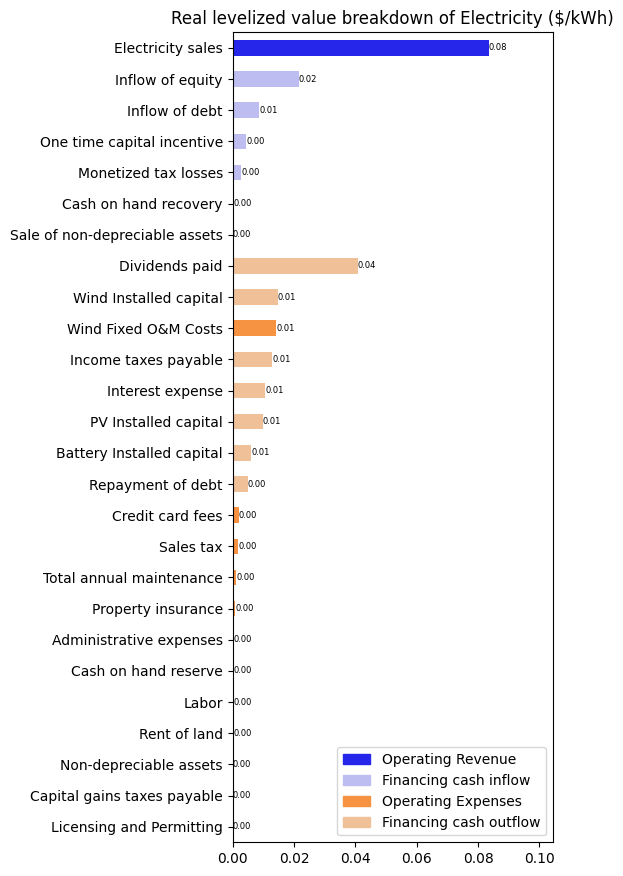

,Type,Name,Amount,NPV
2,Operating Expenses,Licensing and Permitting,"[0.0, 0.0, 0.0, 0.0, 2153.781249999999, 2207.6...",0.000008
3,Financing cash outflow,Capital gains taxes payable,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000011
4,Operating Expenses,Non-depreciable assets,"[-304056, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000062
5,Operating Expenses,Rent of land,"[0.0, 0.0, 0.0, 0.0, 53844.531249999985, 55190...",0.000198
6,Operating Expenses,Labor,"[0.0, 0.0, 0.0, 0.0, 58710.46303927179, 60982....",0.000246
7,Operating Expenses,Cash on hand reserve,"[0.0, 154470.6419666667, 0.0, 0.0, 130772.5676...",0.000255
8,Operating Expenses,Administrative expenses,"[0.0, 0.0, 0.0, 0.0, 113341.94747848381, 11617...",0.000417
9,Operating Expenses,Property insurance,"[0.0, 0.0, 0.0, 0.0, 1121535.504, 897775.70399...",0.000824
10,Operating Expenses,Total annual maintenance,"[0.0, 0.0, 0.0, 0.0, 323067.1874999999, 331143...",0.001189
11,Operating Expenses,Sales tax,"[-0.0, -0.0, -0.0, -0.0, -521372.9584010255, -...",0.001919


In [218]:
pf.plot_costs()

                                 cost
Name                                 
Wind Installed capital     72700000.0
PV Installed capital       48000000.0
Battery Installed capital  29980000.0


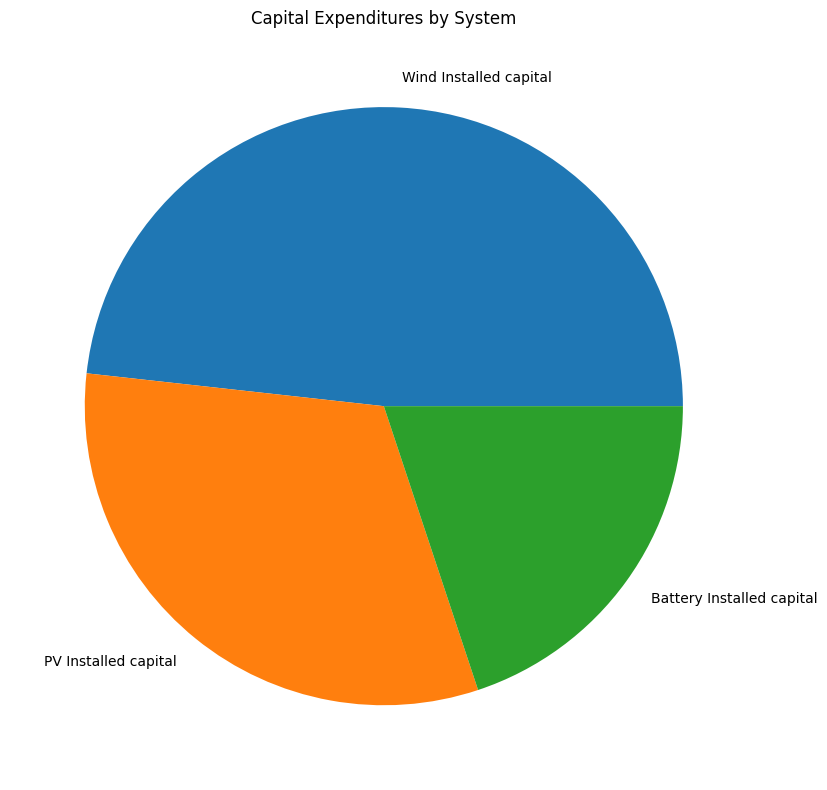

In [219]:
pf.plot_capital_expenses()

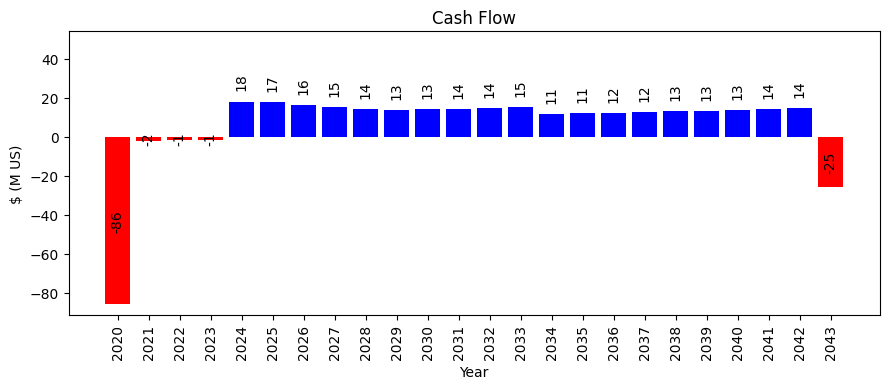

In [220]:
pf.plot_cashflow()